# Heart Failure Prediction
Датасет можно скачать тут: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## 1. Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import itertools
import dill

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

## 2. Загрузка данных

In [2]:
data = pd.read_csv('.\heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


## 3. EDA и очистка данных

### 3.1. Распределение целевой переменной

Positive    508
Negative    410
Name: HeartDisease, dtype: int64


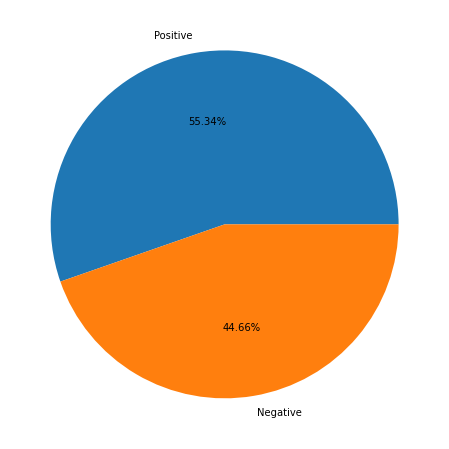

In [5]:
target = 'HeartDisease'
features = data.columns.drop(target)

counts = data[target].value_counts()
counts.rename({1: 'Positive', 0: 'Negative'}, axis='index', inplace=True)
print(counts)
plt.figure(figsize=(8, 8))
plt.pie(x=counts, labels=counts.keys(), autopct="%0.2f%%")
plt.show()

### 3.2. Анализ признаков

In [6]:
categorical = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

### Категориальные признаки

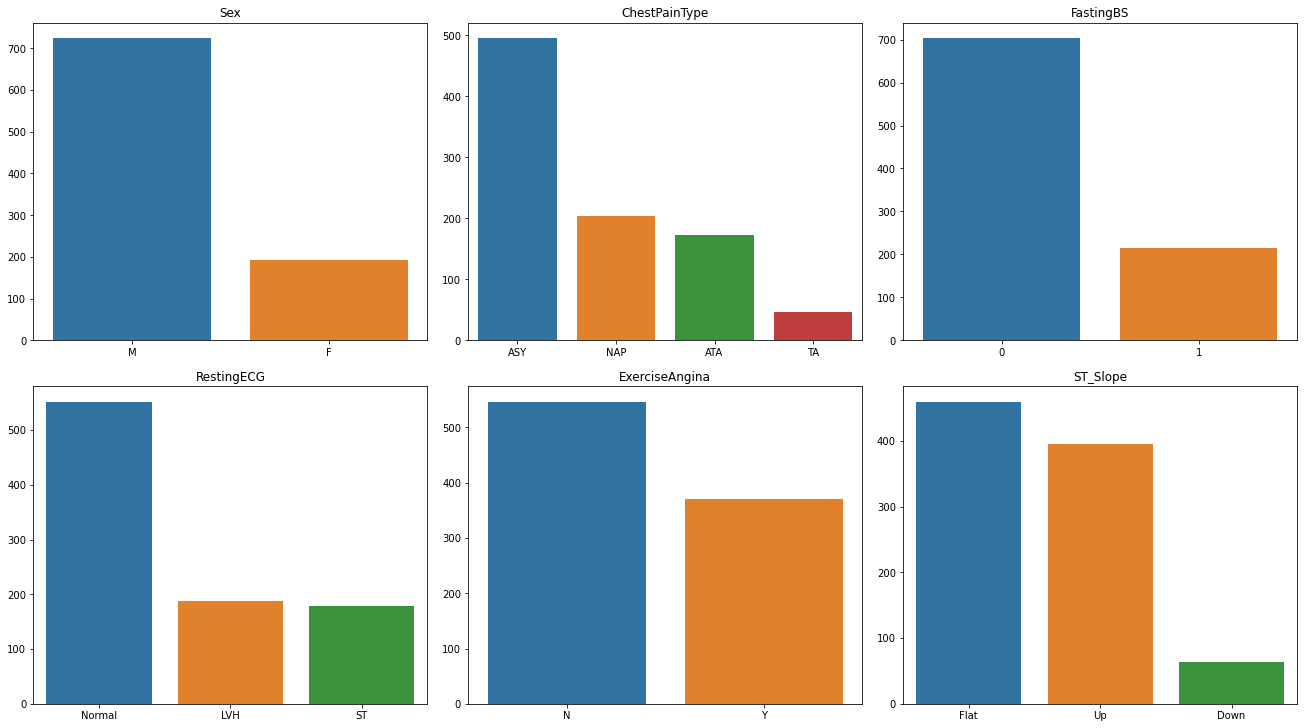

In [7]:
columns_count = 3
lines_count = len(categorical) // columns_count
lines_count += 1 if len(categorical) % columns_count != 0 else 0

_, axes = plt.subplots(lines_count,columns_count,
                         figsize=(18, 10),constrained_layout = True)

xx = 0
yy = 0

for col in categorical:
    counts = data[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, ax=axes[yy, xx])
    axes[yy, xx].set_title(col)

    xx += 1
    if xx >= columns_count:
        xx = 0
        yy += 1
        
plt.show()

### Количественные признаки

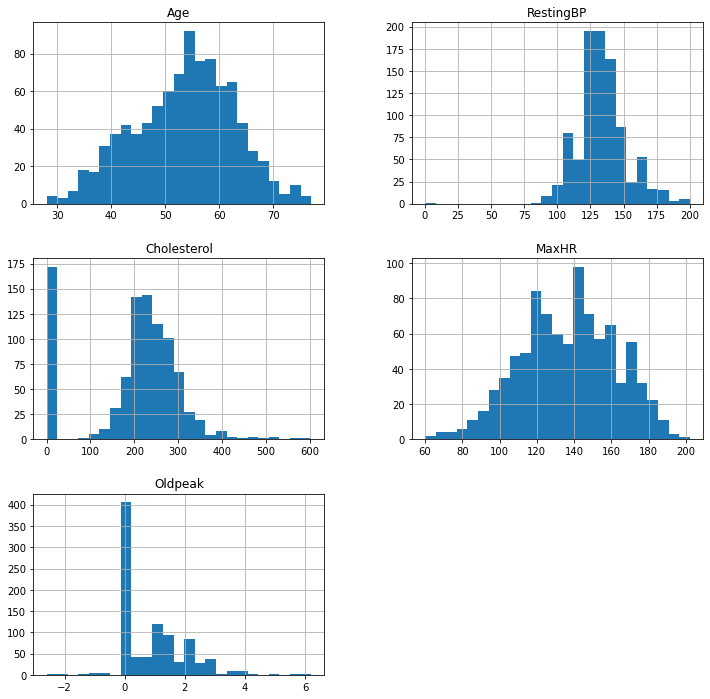

In [8]:
data[numerical].hist(figsize=(12, 12), bins=25)
plt.show()

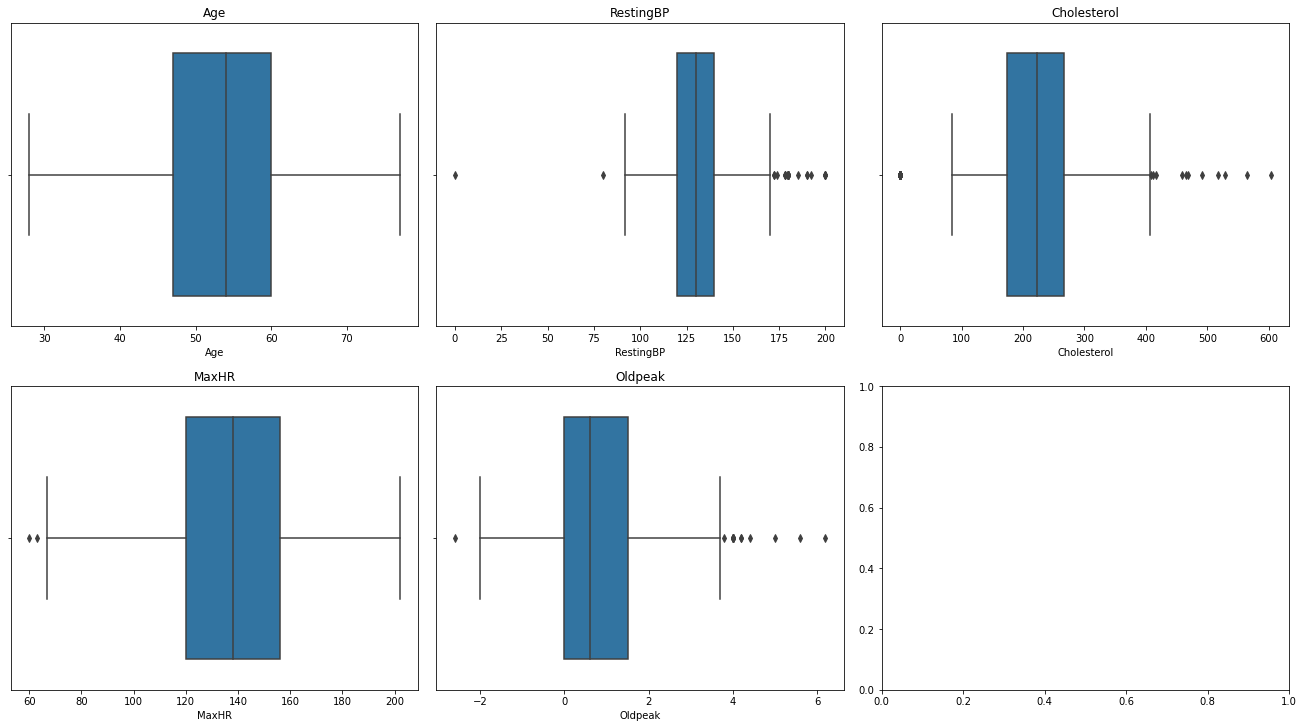

In [9]:
columns_count = 3
lines_count = len(numerical) // columns_count
lines_count += 1 if len(numerical) % columns_count != 0 else 0

_, axes = plt.subplots(lines_count,columns_count,
                         figsize=(18, 10),constrained_layout = True)

xx = 0
yy = 0

for col in numerical:
    sns.boxplot(x=data[col], whis=1.5, ax=axes[yy, xx])
    axes[yy, xx].set_title(col)

    xx += 1
    if xx >= columns_count:
        xx = 0
        yy += 1
        
plt.show()

### Матрица корреляций

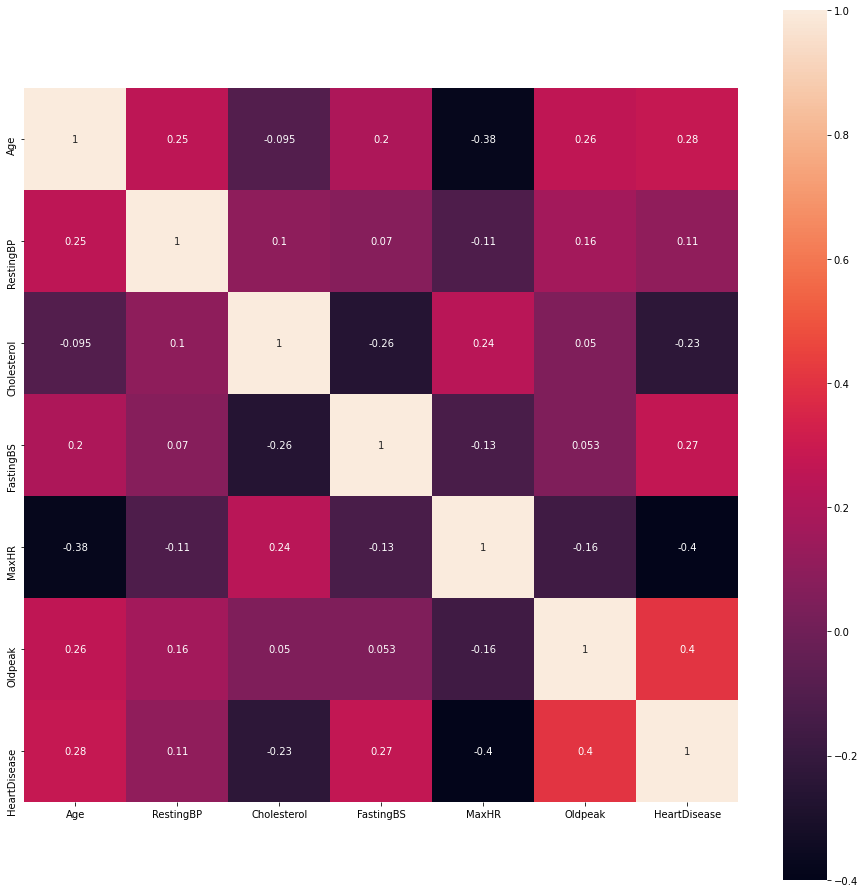

In [10]:
plt.figure(figsize=(16, 16))
sns.heatmap(data.corr(), annot=True, square=True)
plt.show()

## 4: Очистка данных и Feature engineering

In [11]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

class BinomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    
    def fit(self, X, y=None):
        self.values = X.unique()
        return self
    
    def transform(self, X):
        return pd.DataFrame(np.where(X==self.values[0], 0, 1), columns=[self.key])

Оставим только фичи, которые можно измерить дома

In [12]:
categorical = ['ChestPainType'] # 'RestingECG', 'ST_Slope'
numerical = ['Age', 'MaxHR', 'RestingBP'] # , 'Cholesterol', 'Oldpeak', 
binom = ['Sex', 'ExerciseAngina'] # 'FastingBS',

transformers = []
transformers_reg = []

for col in categorical:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=col)),
        ('ohe', OHEEncoder(key=col))
    ])
    transformers.append((col, cat_transformer))
    transformers_reg.append((col, cat_transformer))

for col in binom:
    binom_transformer = Pipeline([
        ('selector', FeatureSelector(column=col)),
        ('binom', BinomEncoder(key=col))
    ])
    transformers.append((col, binom_transformer))
    transformers_reg.append((col, binom_transformer))

for col in numerical:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=col))
    ])
    
    cont_transformer_reg = Pipeline([
        ('selector', NumberSelector(key=col)),
        ('minmax', MinMaxScaler((-1, 1))),
     ])
    transformers.append((col, cont_transformer))
    transformers_reg.append((col, cont_transformer_reg))

feats = FeatureUnion(transformers)
feats_reg = FeatureUnion(transformers_reg)

## 5. Разбиение на train / test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), data[target], test_size=0.2, random_state=24)
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
895,57,M,ASY,110,335,0,Normal,143,Y,3.0,Flat
687,70,M,ATA,156,245,0,LVH,143,N,0.0,Up
422,65,M,ASY,150,236,1,ST,105,Y,0.0,Flat
569,55,M,ASY,158,217,0,Normal,110,Y,2.5,Flat
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat


## 6. Построение модели

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    font = {'size' : 12}
    plt.rc('font', **font)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix" if not title else title
    else:
        title = "Normalized confusion matrix" if not title else title

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(10, 8))
    plt.show()

Step 1:
	Model: LogisticRegression
	Threshold = 0.4066006958085077
	F-Score = 0.8405797101449276
	Precision = 0.7909090909090909
	Recall = 0.8969072164948454


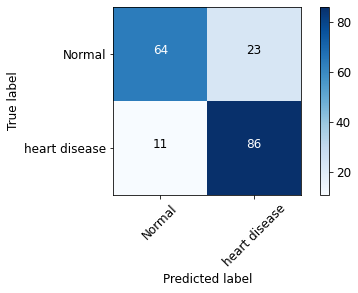

<Figure size 720x576 with 0 Axes>

Step 2:
	Model: SVC
	Threshold = 0.32139230211614156
	F-Score = 0.8333333333333334
	Precision = 0.7563025210084033
	Recall = 0.9278350515463918


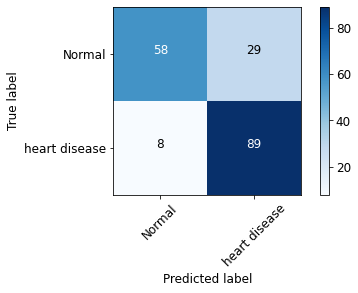

<Figure size 720x576 with 0 Axes>

Step 3:
	Model: RandomForestClassifier
	Threshold = 0.39
	F-Score = 0.8269230769230769
	Precision = 0.7747747747747747
	Recall = 0.8865979381443299


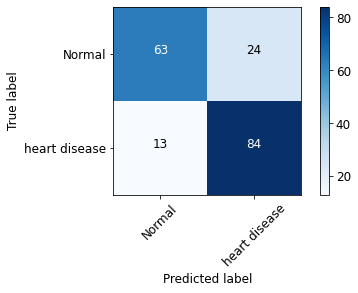

<Figure size 720x576 with 0 Axes>

Step 4:
	Model: GradientBoostingClassifier
	Threshold = 0.42512824598352683
	F-Score = 0.8472906403940886
	Precision = 0.8113207547169812
	Recall = 0.8865979381443299


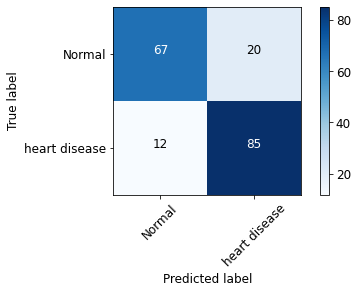

<Figure size 720x576 with 0 Axes>

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = [
    ('classifier', LogisticRegression(random_state = 24)),
    ('classifier', SVC(random_state = 24, probability=True, kernel="linear")),
    ('classifier', RandomForestClassifier(random_state = 24)),
    ('classifier', GradientBoostingClassifier(random_state = 24)),
]
model_names = [
    'LogisticRegression',
    'SVC',
    'RandomForestClassifier',
    'GradientBoostingClassifier',
]

for i in range(len(models)):
    print(f'Step {i+1}:\n\tModel: {model_names[i]}')
    
    if model_names[i] in ['LogisticRegression', 'SVC']:
        pipeline = Pipeline([
            ('features',feats_reg),
            models[i],
        ])
    else:
        pipeline = Pipeline([
            ('features',feats),
            models[i],
        ])
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict_proba(X_test)[:, 1]
   
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    
    print(f'\tThreshold = {thresholds[ix]}')
    print(f'\tF-Score = {fscore[ix]}')
    print(f'\tPrecision = {precision[ix]}')
    print(f'\tRecall = {recall[ix]}')
    
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])    
    plot_confusion_matrix(cnf_matrix, classes=['Normal', 'heart disease'])

Лучший результат показал градиентный бустинг. Будем обучать его.

In [16]:
%%time
params = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__subsample': [0.7, 0.85, 1.0],
    'classifier__max_depth': [3, 5, 7, 9],
}

pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=24)),
])

grid = GridSearchCV(
    pipeline,
    param_grid=params,
)

search = grid.fit(X_train, y_train)
search.best_params_


Wall time: 2min 46s


{'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__subsample': 1.0}

	Threshold = 0.42512824598352683
	F-Score = 0.8472906403940886
	Precision = 0.8113207547169812
	Recall = 0.8865979381443299


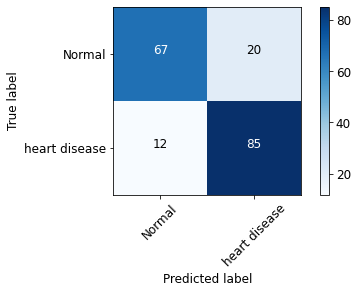

<Figure size 720x576 with 0 Axes>

In [17]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=24)),
])
pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

print(f'\tThreshold = {thresholds[ix]}')
print(f'\tF-Score = {fscore[ix]}')
print(f'\tPrecision = {precision[ix]}')
print(f'\tRecall = {recall[ix]}')

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])    
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'heart disease'])

## Сохранение модели

In [18]:
with open("heart_failure.dill", "wb") as f:
    dill.dump(pipeline, f)